In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the CSV file into a DataFrame
combined_season_data = pd.read_csv('combined_season_data.csv')

# Display the first few rows of the DataFrame
combined_season_data.head()

,Unnamed: 0,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HY,AY,HR,AR,HAGR,AAGR,HAGCR,AAGCR,NAGR,NAGCR
0,0,2002-2003,17/08/2002,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,...,1.0,2.0,0.0,0.0,0.882324,0.750135,0.990630,1.145987,0.816229,1.068309
1,1,2002-2003,17/08/2002,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,...,0.0,3.0,1.0,0.0,0.861645,1.372106,1.167044,0.664697,1.116875,0.915870
2,2,2002-2003,17/08/2002,Everton,Tottenham,2.0,2.0,D,1.0,0.0,...,1.0,1.0,0.0,0.0,1.012637,1.217017,0.939149,0.914164,1.114827,0.926656
3,3,2002-2003,17/08/2002,Fulham,Bolton,4.0,1.0,H,3.0,1.0,...,1.0,2.0,0.0,0.0,0.896110,0.873021,1.133872,1.109798,0.884566,1.121835
4,4,2002-2003,17/08/2002,Leeds,Man City,3.0,0.0,H,2.0,0.0,...,1.0,1.0,0.0,0.0,0.847858,1.391492,1.384168,0.761530,1.119675,1.072849


## Competitiveness Measures

5. Gini Coefficient and Lorenz curve
6. Relative Entropy

### Gini Coefficient and Lorez curve

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = combined_season_data.copy()

# Calculate points for each match
df['HomePts'] = df['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
df['AwayPts'] = df['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))

# Aggregate points for each team per season
home_pts = df.groupby(['Season', 'HomeTeam']).agg({'HomePts': 'sum'}).reset_index()
away_pts = df.groupby(['Season', 'AwayTeam']).agg({'AwayPts': 'sum'}).reset_index()
team_pts = pd.merge(home_pts, away_pts, left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'])
team_pts['TotalPts'] = team_pts['HomePts'] + team_pts['AwayPts']
team_pts = team_pts[['Season', 'HomeTeam', 'TotalPts']]

# Function to calculate Gini coefficient
def gini_coefficient(x):
    n = len(x)
    s = 0
    for i in range(n):
        s += (i+1) * x[i]
    return 1 - 2 * (s / sum(x) - (n + 1) / 2) / n

# Calculate Lorenz curve and Gini coefficient for each season
gini_values = []

for season in team_pts['Season'].unique():
    season_data = team_pts[team_pts['Season'] == season].sort_values(by='TotalPts')
    season_data['CumulativePts'] = season_data['TotalPts'].cumsum()
    season_data['CumulativePct'] = season_data['CumulativePts'] / season_data['TotalPts'].sum()
    season_data['TeamPct'] = (season_data.index + 1) / len(season_data)
    
    # Compute Gini coefficient
    gini = gini_coefficient(season_data['CumulativePct'].values)
    gini_values.append((season, gini))

gini_df = pd.DataFrame(gini_values, columns=['Season', 'GiniCoefficient'])

gini_df


,Season,GiniCoefficient
0,2002-2003,0.622385
1,2003-2004,0.632525
2,2004-2005,0.626881
3,2005-2006,0.607365
4,2006-2007,0.625998
5,2007-2008,0.603196
6,2008-2009,0.621094
7,2009-2010,0.609931
8,2010-2011,0.640887
9,2011-2012,0.618892


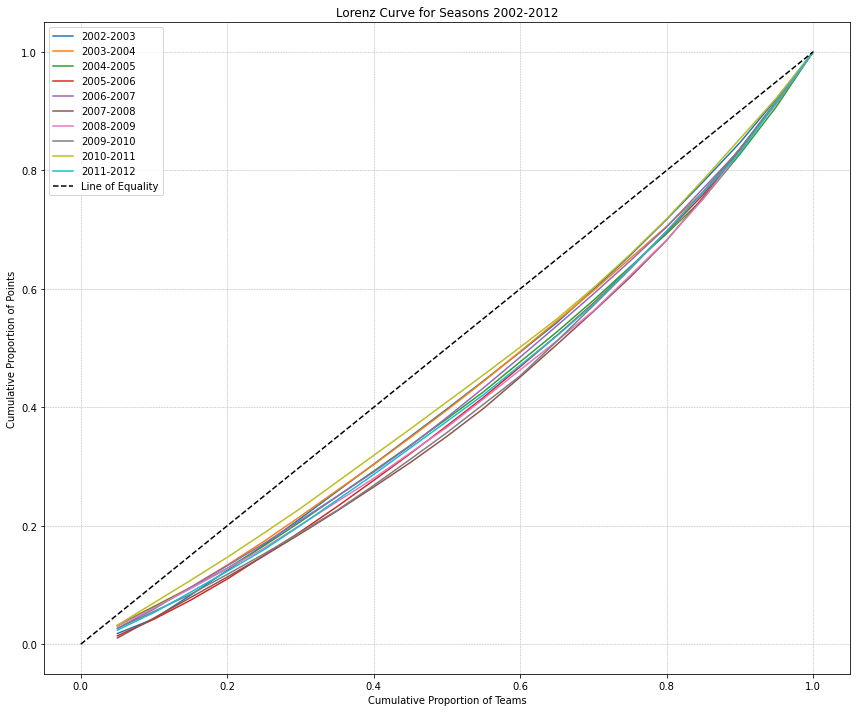

In [11]:
# Filter the data for the seasons 2002-2012
filtered_seasons = ["2002-2003", "2003-2004", "2004-2005", "2005-2006", "2006-2007", "2007-2008", 
                    "2008-2009", "2009-2010", "2010-2011", "2011-2012"]

filtered_data = combined_season_data[combined_season_data['Season'].isin(filtered_seasons)]

# Redefine the function to compute Lorenz curve
def compute_lorenz_curve(points):
    sorted_points = np.sort(points)
    total_points = sorted_points.sum()
    cumulative_points = np.cumsum(sorted_points) / total_points
    cumulative_teams = np.arange(1, len(sorted_points) + 1) / len(sorted_points)
    return cumulative_teams, cumulative_points

# Calculate the total points for each team per season
def calculate_team_points(df):
    # 3 points for a win, 1 point for a draw
    df['HomePts'] = np.where(df['FTR'] == 'H', 3, np.where(df['FTR'] == 'D', 1, 0))
    df['AwayPts'] = np.where(df['FTR'] == 'A', 3, np.where(df['FTR'] == 'D', 1, 0))
    
    # Aggregate points for each team
    home_points = df.groupby(['Season', 'HomeTeam'])['HomePts'].sum().reset_index()
    away_points = df.groupby(['Season', 'AwayTeam'])['AwayPts'].sum().reset_index()
    
    home_points.rename(columns={'HomeTeam': 'Team', 'HomePts': 'Points'}, inplace=True)
    away_points.rename(columns={'AwayTeam': 'Team', 'AwayPts': 'Points'}, inplace=True)
    
    total_points = pd.concat([home_points, away_points], axis=0)
    total_points = total_points.groupby(['Season', 'Team'])['Points'].sum().reset_index()
    
    return total_points

team_points = calculate_team_points(combined_season_data)

# Filter for seasons 2002-2012
team_points_filtered = team_points[team_points['Season'].isin(filtered_seasons)]

# Compute the Lorenz curve values for the filtered seasons using the points data
lorenz_curves = {}
for season in filtered_seasons:
    season_data = team_points_filtered[team_points_filtered['Season'] == season]
    lorenz_x, lorenz_y = compute_lorenz_curve(season_data['Points'])
    lorenz_curves[season] = (lorenz_x, lorenz_y)

# Plotting
plt.figure(figsize=(12, 10))
for season, (lx, ly) in lorenz_curves.items():
    plt.plot(lx, ly, label=season)

# Plotting the line of equality
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Line of Equality")

plt.title('Lorenz Curve for Seasons 2002-2012')
plt.xlabel('Cumulative Proportion of Teams')
plt.ylabel('Cumulative Proportion of Points')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# Save the plot as a PDF
file_path = "C:/Users/HP/Desktop/DissertationPrograms/Final_Work/Images/pdf/L1.pdf"
plt.savefig(file_path)
plt.show()


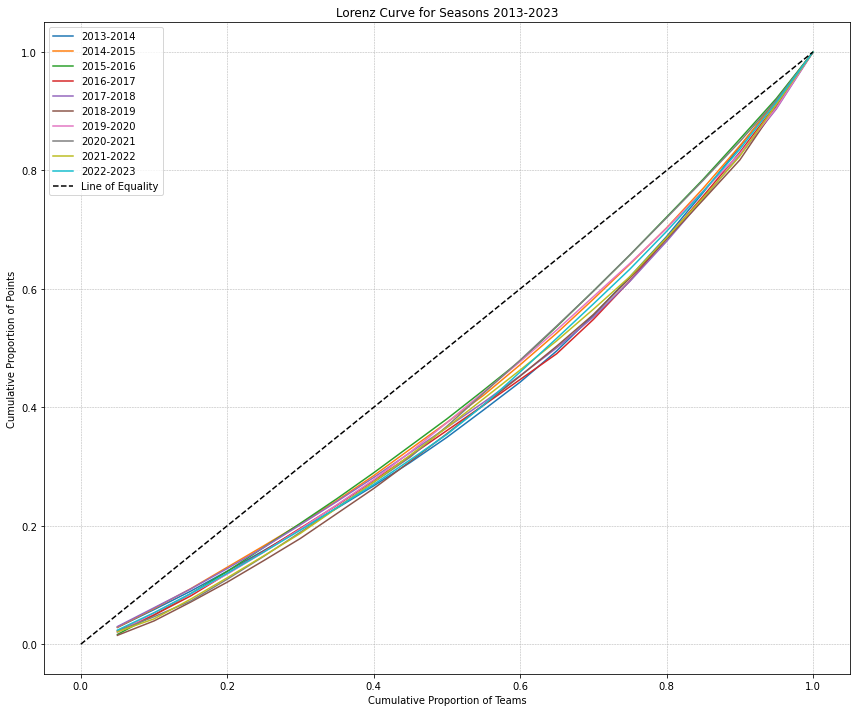

In [12]:
# Filter the data for the seasons 2002-2012
filtered_seasons = ['2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']


filtered_data = combined_season_data[combined_season_data['Season'].isin(filtered_seasons)]

# define the function to compute Lorenz curve
def compute_lorenz_curve(points):
    sorted_points = np.sort(points)
    total_points = sorted_points.sum()
    cumulative_points = np.cumsum(sorted_points) / total_points
    cumulative_teams = np.arange(1, len(sorted_points) + 1) / len(sorted_points)
    return cumulative_teams, cumulative_points

# Calculate the total points for each team per season
def calculate_team_points(df):
    # 3 points for a win, 1 point for a draw
    df['HomePts'] = np.where(df['FTR'] == 'H', 3, np.where(df['FTR'] == 'D', 1, 0))
    df['AwayPts'] = np.where(df['FTR'] == 'A', 3, np.where(df['FTR'] == 'D', 1, 0))
    
    # Aggregate points for each team
    home_points = df.groupby(['Season', 'HomeTeam'])['HomePts'].sum().reset_index()
    away_points = df.groupby(['Season', 'AwayTeam'])['AwayPts'].sum().reset_index()
    
    home_points.rename(columns={'HomeTeam': 'Team', 'HomePts': 'Points'}, inplace=True)
    away_points.rename(columns={'AwayTeam': 'Team', 'AwayPts': 'Points'}, inplace=True)
    
    total_points = pd.concat([home_points, away_points], axis=0)
    total_points = total_points.groupby(['Season', 'Team'])['Points'].sum().reset_index()
    
    return total_points

team_points = calculate_team_points(combined_season_data)

# Filter for seasons 2002-2012
team_points_filtered = team_points[team_points['Season'].isin(filtered_seasons)]

# Compute the Lorenz curve values for the filtered seasons using the points data
lorenz_curves = {}
for season in filtered_seasons:
    season_data = team_points_filtered[team_points_filtered['Season'] == season]
    lorenz_x, lorenz_y = compute_lorenz_curve(season_data['Points'])
    lorenz_curves[season] = (lorenz_x, lorenz_y)

# Plotting
plt.figure(figsize=(12, 10))
for season, (lx, ly) in lorenz_curves.items():
    plt.plot(lx, ly, label=season)

# Plotting the line of equality
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Line of Equality")

plt.title('Lorenz Curve for Seasons 2013-2023')
plt.xlabel('Cumulative Proportion of Teams')
plt.ylabel('Cumulative Proportion of Points')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# Save the plot as a PDF
file_path = "C:/Users/HP/Desktop/DissertationPrograms/Final_Work/Images/pdf/L2.pdf"
plt.savefig(file_path)
plt.show()


In [6]:
# Most and least competitive year based on Gini Coefficient
most_competitive_year_gini = gini_df['Season'][gini_df['GiniCoefficient'].idxmin()]
least_competitive_year_gini = gini_df['Season'][gini_df['GiniCoefficient'].idxmax()]

# Current trend of competitiveness balance for Gini Coefficient
# Calculate the percentage change over the last 5 years to determine the trend
recent_gini_trend = gini_df['GiniCoefficient'].tail(5).pct_change().mean()

# Predicting future trend using linear regression for Gini Coefficient
from sklearn.linear_model import LinearRegression

X = np.array(range(len(gini_df))).reshape(-1, 1)  # Using the index as a time variable
y = gini_df['GiniCoefficient'].values
reg = LinearRegression().fit(X, y)
future_gini_trend_slope = reg.coef_[0]

most_competitive_year_gini, least_competitive_year_gini, recent_gini_trend, future_gini_trend_slope


('2018-2019', '2010-2011', 0.004347723837218598, -0.0007246515131432279)

### Relative Entropy

In [7]:
# Calculate win percentage for each team for each game
df['HomeWin'] = (df['FTR'] == 'H').astype(int)
df['AwayWin'] = (df['FTR'] == 'A').astype(int)

# Calculating win percentages for home and away games separately
home_stats = df.groupby(['Season', 'HomeTeam']).agg(HomeGames=('HomeTeam', 'size'), HomeWins=('HomeWin', 'sum')).reset_index()
away_stats = df.groupby(['Season', 'AwayTeam']).agg(AwayGames=('AwayTeam', 'size'), AwayWins=('AwayWin', 'sum')).reset_index()

# Merging home and away statistics based on season and team
team_stats = pd.merge(home_stats, away_stats, left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'])

# Calculating total games played, total wins, and win percentage for each team for each season
team_stats['TotalGames'] = team_stats['HomeGames'] + team_stats['AwayGames']
team_stats['TotalWins'] = team_stats['HomeWins'] + team_stats['AwayWins']
team_stats['WPCT'] = team_stats['TotalWins'] / team_stats['TotalGames']

# Combine NAGR and NAGCR columns from the original dataframe
team_stats = pd.merge(team_stats, df[['Season', 'HomeTeam', 'NAGR', 'NAGCR']].drop_duplicates(), on=['Season', 'HomeTeam'])


In [8]:
df = combined_season_data.copy()

# Calculating Relative Entropy for Win Percentage, NAGR, and NAGCR

def calculate_relative_entropy(df, column):
    """Calculate the relative entropy for a given column."""
    # Calculate pi (proportion of total wins or metric value in the league season for team i)
    df['pi'] = df[column] / df.groupby('Season')[column].transform('sum')
    
    # Calculate E (actual entropy)
    df['E'] = -df['pi'] * np.log2(df['pi'])
    E_values = df.groupby('Season')['E'].sum().reset_index()
    
    # Calculate Emax (maximum possible entropy)
    N = df.groupby('Season')['HomeTeam'].nunique().reset_index(name='N')
    Emax_values = -np.log2(1/N['N'])
    
    # Calculate Relative Entropy R
    R = E_values['E'] / Emax_values
    
    return R

# Calculate Relative Entropy for each metric
R_WinPct = calculate_relative_entropy(team_stats, 'WPCT')
R_NAGR = calculate_relative_entropy(team_stats, 'NAGR')
R_NAGCR = calculate_relative_entropy(team_stats, 'NAGCR')

# Combine the results into a DataFrame
relative_entropy_df = pd.DataFrame({
    'Season': team_stats['Season'].unique(),
    'RE(WinPct)': R_WinPct,
    'RE(NAGR)': R_NAGR,
    'RE(NAGCR)': R_NAGCR
})

relative_entropy_df


,Season,RE(WinPct),RE(NAGR),RE(NAGCR)
0,2002-2003,1.961558,1.978516,1.980143
1,2003-2004,1.959745,1.978666,1.980294
2,2004-2005,1.951234,1.978045,1.980236
3,2005-2006,1.953463,1.978120,1.980514
4,2006-2007,1.958698,1.977782,1.980334
5,2007-2008,1.945636,1.976585,1.978482
6,2008-2009,1.954054,1.977825,1.980313
7,2009-2010,1.951653,1.977462,1.980304
8,2010-2011,1.965678,1.978219,1.979401
9,2011-2012,1.953904,1.977573,1.979783


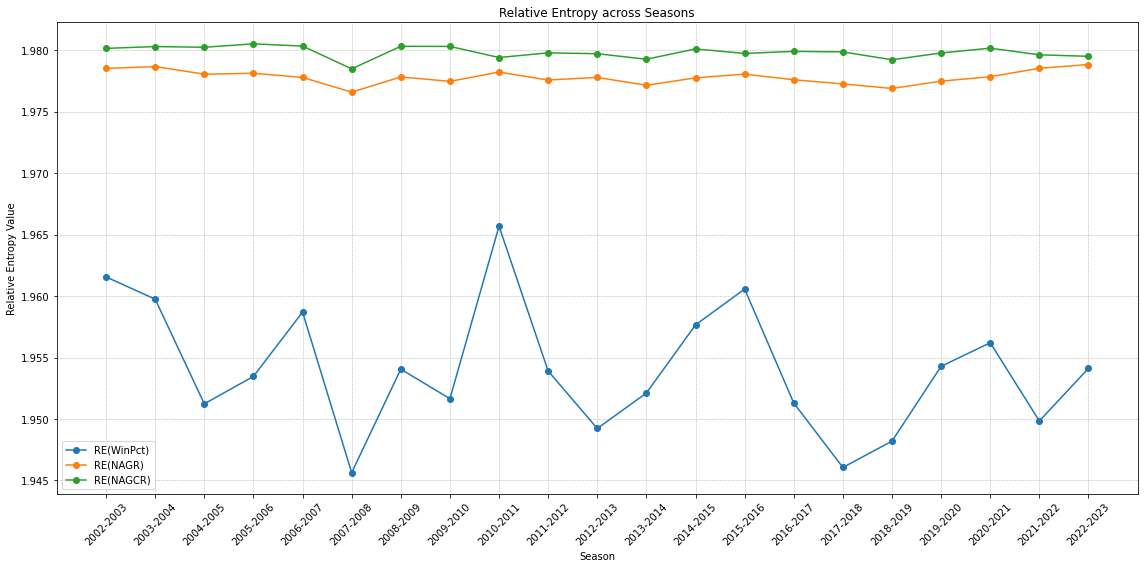

In [13]:
# Plotting Relative Entropy values for each metric across seasons
plt.figure(figsize=(16, 8))

plt.plot(relative_entropy_df['Season'], relative_entropy_df['RE(WinPct)'], label='RE(WinPct)', marker='o')
plt.plot(relative_entropy_df['Season'], relative_entropy_df['RE(NAGR)'], label='RE(NAGR)', marker='o')
plt.plot(relative_entropy_df['Season'], relative_entropy_df['RE(NAGCR)'], label='RE(NAGCR)', marker='o')

# Setting labels, title, and legend
plt.xlabel('Season')
plt.ylabel('Relative Entropy Value')
plt.title('Relative Entropy across Seasons')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# Save the plot as a PDF
file_path = "C:/Users/HP/Desktop/DissertationPrograms/Final_Work/Images/pdf/RE.pdf"
plt.savefig(file_path)
plt.show()


In [10]:
from sklearn.linear_model import LinearRegression

# Assigning trend labels
def determine_trend(value):
    if value > 0.01:  # Threshold of 1% used to determine if value is effectively increasing
        return "Increasing"
    elif value < -0.01:  # Threshold of -1% used to determine if value is effectively decreasing
        return "Declining"
    else:
        return "Stable"

# Most and least competitive year based on Relative Entropy for WinPct
most_competitive_year_RE = relative_entropy_df['Season'][relative_entropy_df['RE(WinPct)'].idxmax()]
least_competitive_year_RE = relative_entropy_df['Season'][relative_entropy_df['RE(WinPct)'].idxmin()]

# Current trend of competitiveness balance for Relative Entropy for WinPct
recent_RE_trend = relative_entropy_df['RE(WinPct)'].tail(5).pct_change().mean()

# Determining the trend
current_trend_RE = determine_trend(recent_RE_trend)

# Modifying the code to forecast using linear regression for Relative Entropy for WinPct

# Setting up the data for linear regression
X = np.array(range(len(relative_entropy_df))).reshape(-1, 1)

# Fitting linear regression to the data
model_RE = LinearRegression().fit(X, relative_entropy_df['RE(WinPct)'])
forecast_RE = model_RE.predict(X[-5:])  # Forecast for the last 5 seasons

# Using the mean percentage change of the forecast to predict future trend
future_trend_RE_linear = determine_trend(np.mean(np.diff(forecast_RE)))

most_competitive_year_RE, least_competitive_year_RE, current_trend_RE, future_trend_RE_linear


('2010-2011', '2007-2008', 'Stable', 'Stable')